# Example for Logistic Regression
## Jan 12, 2018

In [1]:
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

/Users/davidspencerkartchner/anaconda/envs/py36/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Read in and preprocess data

In [2]:
data = pd.read_csv('birthweight.tsv', 
                   delim_whitespace=True, 
                   header=0,
                   names = ['low','age','mother_wt','race','smoke',
                            'high_bp','ui','first_tri_visits',
                            'prev_prem_lbr','bwt'])
data.head()

,low,age,mother_wt,race,smoke,high_bp,ui,first_tri_visits,prev_prem_lbr,bwt
0,0,19,182,black,0,0,1,0,0,2523
1,0,33,155,other,0,0,0,1,0,2551
2,0,20,105,white,1,0,0,1,0,2557
3,0,21,108,white,1,0,1,1,0,2594
4,0,18,107,white,1,0,1,0,0,2600


In [3]:
# Clean data and add necessary columns
data = pd.get_dummies(data, columns=['race'], drop_first=True)

# Shuffle dataframe
data = data.sample(frac=1)

# Make dependent variable
y = data.low.as_matrix()

#Drop columns that don't matter
data = data.drop(['bwt','low'], axis=1)

# Add column for constant
x = sm.add_constant(data)

x.head()

,const,age,mother_wt,smoke,high_bp,ui,first_tri_visits,prev_prem_lbr,race_other,race_white
27,1.0,29,150,0,0,0,1,0,0,1
8,1.0,29,123,1,0,0,1,0,0,1
107,1.0,22,169,0,0,0,0,0,0,1
184,1.0,28,95,1,0,0,1,0,0,1
72,1.0,23,115,1,0,0,1,0,1,0


### Build Logit model with statsmodels

First, we try a simple model based on race of mother

In [4]:
# Build basic logit model
model = sm.Logit(y, x[['const','race_other','race_white']])
results = model.fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.607570
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  189
Model:                          Logit   Df Residuals:                      186
Method:                           MLE   Df Model:                            2
Date:                Fri, 12 Jan 2018   Pseudo R-squ.:                 0.02135
Time:                        09:55:53   Log-Likelihood:                -114.83
converged:                       True   LL-Null:                       -117.34
                                        LLR p-value:                   0.08166
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3102      0.397     -0.781      0.435      -1.088       0.468
race_other    -0.2086      0.

Nothing seems to have a significant affect on whether or not a child is low birthweight.  Let's try adding some other variables

In [5]:
model = sm.Logit(y,x[['const','race_other','race_white','age','smoke','mother_wt','high_bp']])
results = model.fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.550223
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  189
Model:                          Logit   Df Residuals:                      182
Method:                           MLE   Df Model:                            6
Date:                Fri, 12 Jan 2018   Pseudo R-squ.:                  0.1137
Time:                        09:55:53   Log-Likelihood:                -103.99
converged:                       True   LL-Null:                       -117.34
                                        LLR p-value:                 0.0001657
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0065      1.225      1.638      0.101      -0.395       4.408
race_other    -0.3161      0.

What happens if the mother has a history of premature labor or uterine irritation?

In [6]:
model = sm.Logit(y,x[['const','race_other','race_white','age','smoke',
                      'mother_wt','high_bp','ui','prev_prem_lbr']])
results = model.fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.520893
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  189
Model:                          Logit   Df Residuals:                      180
Method:                           MLE   Df Model:                            8
Date:                Fri, 12 Jan 2018   Pseudo R-squ.:                  0.1610
Time:                        09:55:53   Log-Likelihood:                -98.449
converged:                       True   LL-Null:                       -117.34
                                        LLR p-value:                 8.286e-06
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.8416      1.287      1.431      0.153      -0.681       4.364
race_other       -0.

**Let's plot the probability as a function of $w^Tx$**

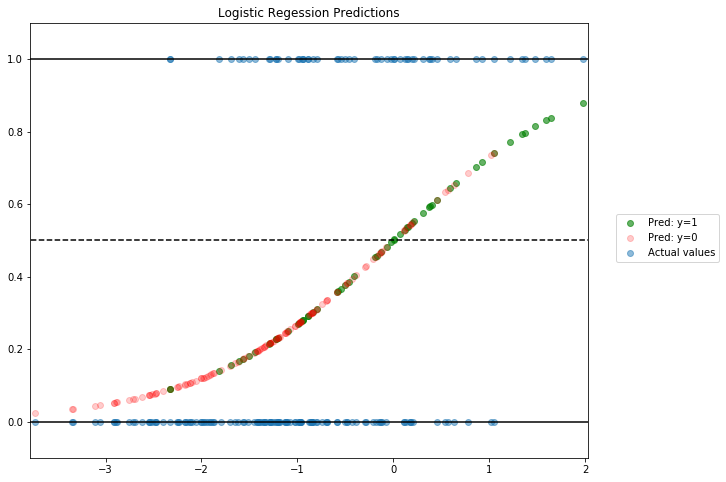

In [8]:
# Get values of w^T*x
w = results.params.as_matrix()
curr_x = x[['const','race_other','race_white','age','smoke',
          'mother_wt','high_bp','ui','prev_prem_lbr']].as_matrix()
wtx = curr_x @ w

# Get predicted probabilities
preds = results.predict(x[['const','race_other','race_white','age','smoke',
                      'mother_wt','high_bp','ui','prev_prem_lbr']])

# Plot results
grid_points = np.linspace(wtx.min()-1, wtx.max()+1, 10)
plt.figure(figsize=(10,8))
plt.title("Logistic Regession Predictions")
plt.ylim(-.1,1.1)
plt.xlim(wtx.min()-.05, wtx.max()+.05)
plt.plot(grid_points, np.zeros_like(grid_points), color='k')
plt.plot(grid_points, np.ones_like(grid_points), color='k')
plt.plot(grid_points, .5*np.ones_like(grid_points), '--k')
plt.scatter(wtx[y==1], preds[y==1], label="Pred: y=1", alpha=.6, color='g')
plt.scatter(wtx[y==0], preds[y==0], label='Pred: y=0', alpha=.2, color='r')
plt.scatter(wtx, y, label="Actual values", alpha=.5)
plt.legend(loc=(1.05, .45))
plt.show()